## Variant effect prediction: Three models for classifying pathogenic mutations in human genes

To run this demo tutorial, please make sure that you've downloaded the GitHub repo <> and that you've changed the 'main_path' variable below to point to where your installation lives on your local system. If you are not using Google Colab to run, please also set the 'using_google_colab' variable to False.

In [121]:
# Change this to whatever your directory you're working from is - this should be
# the head level with Code and Data directories.
main_path = '/content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/'

# Input the uniprot ID that you would like to make predictions for here.
# For this demonstration, I will use the KCNQ1 gene 
# (https://www.uniprot.org/uniprotkb/P51787/entry)
uniprot_id = 'P51787'

# Set to False if you're running locally
using_google_colab = True

In [122]:
import matplotlib.pyplot as plt
import pandas as pd
import keras
import numpy as np
from keras import models
from keras import layers
from keras.layers import GRU, LSTM
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
import copy
import random as python_random
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint
from google.colab import files
import sklearn.preprocessing
import scipy

import sys
import importlib

# set seeds
np.random.seed(768)
python_random.seed(869)
tf.random.set_seed(1234)

if using_google_colab:
  from google.colab import drive
  drive.mount('/content/drive')

sys.path.append(main_path+"Code")

# This is our library with our class definitions
import vep
importlib.reload(vep)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'vep' from '/content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/Code/vep.py'>

## Model 1 - predicting pathogenicity based just on the original ("wildtype") and the mutant amino acids

In [123]:
# Instantiate a Protein class for our protein (specified by Uniprot ID) of 
# interest
uniprot = vep.Protein(uniprot_id)

In [124]:
m1 = vep.Model1()
m1.load_nn_model_from_weights(main_path+'Code/Trained_Model_Weights/Model1')

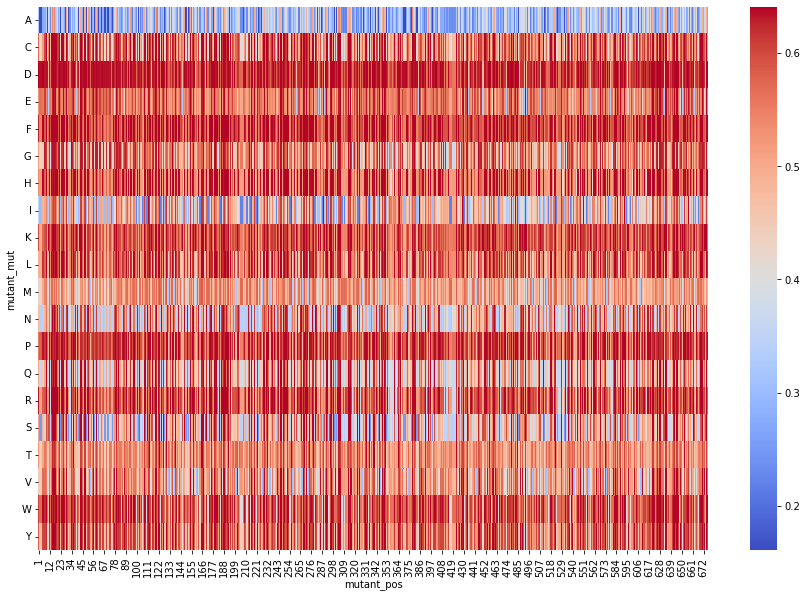

In [125]:
uniprot.test_all_single_aa_subs(m1)
uniprot.plot_heatmap_pathogenicity(set_wt_to_zero=False)

In [126]:
uniprot.predictions

,uniprot,mutant_wt,mutant_mut,mutant_pos,Sequence,Length,pred_pathogenic
0,P51787,M,A,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.324157
1,P51787,M,C,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.568725
2,P51787,M,D,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.640716
3,P51787,M,E,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.521455
4,P51787,M,F,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.626046
...,...,...,...,...,...,...,...
13515,P51787,S,S,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.476831
13516,P51787,S,T,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.506383
13517,P51787,S,V,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.569596
13518,P51787,S,W,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.637805


## Model 2

In [127]:
m2 = vep.Model2(main_path+'Data/precursor_files/amino_acid_properties.csv')
m2.load_nn_model_from_weights(main_path+'Code/Trained_Model_Weights/Model2_clustered')

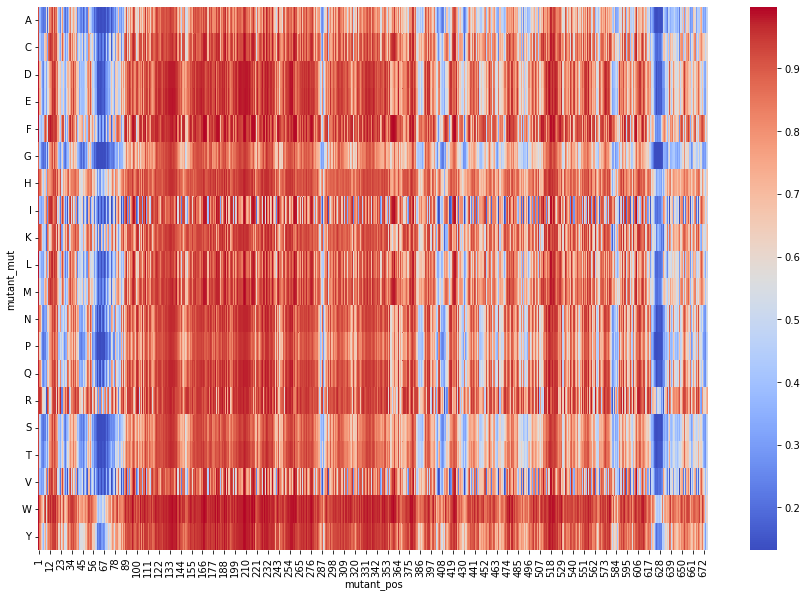

In [128]:
uniprot2 = vep.Protein(uniprot_id)
uniprot2.test_all_single_aa_subs(m2)
uniprot2.plot_heatmap_pathogenicity(set_wt_to_zero=False)

In [129]:
uniprot2.predictions

,uniprot,mutant_wt,mutant_mut,mutant_pos,Sequence,Length,pred_pathogenic
0,P51787,M,A,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.922557
1,P51787,M,C,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.943632
2,P51787,M,D,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.982255
3,P51787,M,E,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.988003
4,P51787,M,F,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.987160
...,...,...,...,...,...,...,...
13515,P51787,S,S,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.521694
13516,P51787,S,T,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.505762
13517,P51787,S,V,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.477422
13518,P51787,S,W,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.593022
